# LGBM - Training

Sources
1. [LGBM & Deberta Explained by ZULQARNAIN ALI](https://www.kaggle.com/code/zulqarnainalipk/lgbm-deberta-explained)

## Setup

In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
os.chdir("../../")

In [ ]:
from lib.config import config
from lib.paths import Paths
from lib.utils.utils import seed_everything
from lib.model.utils import get_score

In [ ]:
seed_everything()

## Model Training

### Dataset Creation

In [5]:
df = pd.read_csv(Paths.FEATURE_ENGG_CSV_PATH)
df.shape

(17307, 21867)

In [6]:
X, y = df.drop(columns=["score", "essay_id"]), df.loc[:, "score"]
del df

X.shape, y.shape

((17307, 21865), (17307,))

In [7]:
X, y = X.to_numpy(), y.to_numpy()

### Callbacks

In [8]:
from lightgbm import log_evaluation, early_stopping

In [9]:
callbacks = [
    log_evaluation(period=25),
    early_stopping(stopping_rounds=75, first_metric_only=True),
]

### Scoring Functions

In [10]:
from sklearn.metrics import cohen_kappa_score

In [11]:
a = 2.998
b = 1.092

In [12]:
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return "QWK", qwk, True


def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1 / 2 * np.sum((preds - labels) ** 2)
    g = 1 / 2 * np.sum((preds - a) ** 2 + b)
    df = preds - labels
    dg = preds - a
    grad = (df / g - f * dg / g**2) * len(labels)
    hess = np.ones(len(labels))
    return grad, hess

### Training Loop

In [13]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

In [22]:
def train_loop(X_train, y_train, X_valid, y_valid):
    y_valid_int = y_valid.astype(np.int64)
    y_train = y_train.astype(np.float32) - a
    y_valid = y_valid.astype(np.float32) - a

    model = lgb.LGBMRegressor(
        objective=qwk_obj,
        metrics="None",
        learning_rate=0.01,
        max_depth=5,
        num_leaves=10,
        colsample_bytree=0.3,
        reg_alpha=0.7,
        reg_lambda=0.1,
        n_estimators=700,
        random_state=config.random_seed,
        extra_trees=True,
        class_weight="balanced",
        n_jobs=6,
        verbosity=-1,
    )

    # Train model
    predictor = model.fit(
        X_train,
        y_train,
        eval_names=["train", "valid"],
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_metric=quadratic_weighted_kappa,
        callbacks=callbacks,
    )

    # Validate model
    preds = predictor.predict(X_valid)
    preds = preds + a
    preds = preds.clip(1, 6).round()
    f1 = f1_score(y_valid_int, preds, average="weighted")
    qwk = cohen_kappa_score(y_valid_int, preds, weights="quadratic")

    print(f"F1 Score: {f1:<8.7f}\t\tQWK Score: {qwk:>8.7f}")

    cm = confusion_matrix(y_valid_int, preds, labels=list(range(1, 7)))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1, 7)))
    disp.plot()
    plt.show()

    return predictor

### Fold Loop

In [19]:
from sklearn.model_selection import StratifiedKFold
import pickle as pkl

In [20]:
skf = StratifiedKFold(
    n_splits=config.n_folds,
    random_state=config.random_seed,
    shuffle=True,
)

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.190524	valid's QWK: 0.202662
[50]	train's QWK: 0.655558	valid's QWK: 0.645902
[75]	train's QWK: 0.70411	valid's QWK: 0.696338
[100]	train's QWK: 0.735872	valid's QWK: 0.736022
[125]	train's QWK: 0.755454	valid's QWK: 0.757825
[150]	train's QWK: 0.768771	valid's QWK: 0.767753
[175]	train's QWK: 0.776219	valid's QWK: 0.77272
[200]	train's QWK: 0.784762	valid's QWK: 0.781171
[225]	train's QWK: 0.793751	valid's QWK: 0.790294
[250]	train's QWK: 0.797168	valid's QWK: 0.795592
[275]	train's QWK: 0.802339	valid's QWK: 0.798618
[300]	train's QWK: 0.804436	valid's QWK: 0.800727
[325]	train's QWK: 0.80747	valid's QWK: 0.801132
[350]	train's QWK: 0.809352	valid's QWK: 0.803257
[375]	train's QWK: 0.811802	valid's QWK: 0.803709
[400]	train's QWK: 0.813369	valid's QWK: 0.803379
[425]	train's QWK: 0.815029	valid's QWK: 0.804334
[450]	train's QWK: 0.816117	valid's QWK

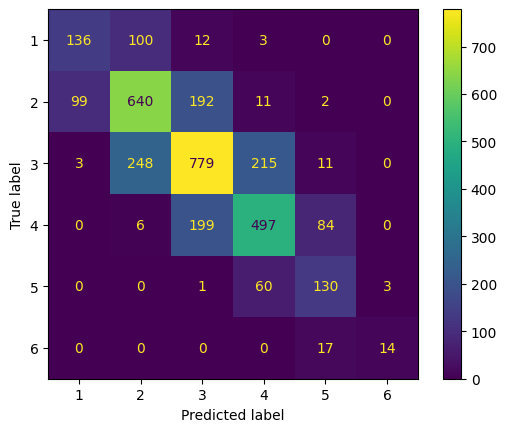

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.167635	valid's QWK: 0.147213
[50]	train's QWK: 0.655776	valid's QWK: 0.654529
[75]	train's QWK: 0.703387	valid's QWK: 0.697668
[100]	train's QWK: 0.733702	valid's QWK: 0.725157
[125]	train's QWK: 0.755551	valid's QWK: 0.747955
[150]	train's QWK: 0.767548	valid's QWK: 0.759839
[175]	train's QWK: 0.776461	valid's QWK: 0.768854
[200]	train's QWK: 0.783981	valid's QWK: 0.775788
[225]	train's QWK: 0.791367	valid's QWK: 0.785766
[250]	train's QWK: 0.796105	valid's QWK: 0.789956
[275]	train's QWK: 0.799663	valid's QWK: 0.795872
[300]	train's QWK: 0.803917	valid's QWK: 0.798221
[325]	train's QWK: 0.80641	valid's QWK: 0.799395
[350]	train's QWK: 0.807995	valid's QWK: 0.80067
[375]	train's QWK: 0.810149	valid's QWK: 0.802147
[400]	train's QWK: 0.811282	valid's QWK: 0.801956
[425]	train's QWK: 0.813906	valid's QWK: 0.802125
[450]	train's QWK: 0.814479	valid's QW

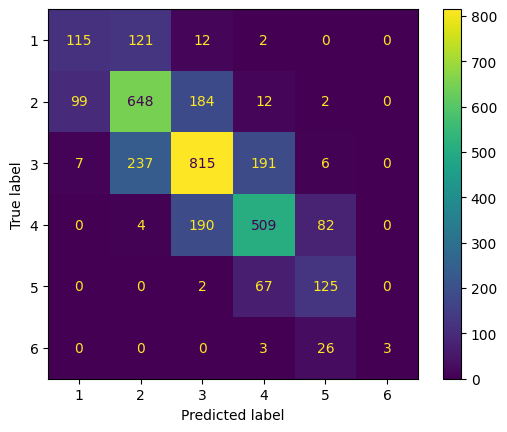

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.205359	valid's QWK: 0.204642
[50]	train's QWK: 0.648075	valid's QWK: 0.664674
[75]	train's QWK: 0.699481	valid's QWK: 0.711246
[100]	train's QWK: 0.735084	valid's QWK: 0.740091
[125]	train's QWK: 0.756816	valid's QWK: 0.756373
[150]	train's QWK: 0.768079	valid's QWK: 0.764996
[175]	train's QWK: 0.777991	valid's QWK: 0.773978
[200]	train's QWK: 0.785155	valid's QWK: 0.781654
[225]	train's QWK: 0.793262	valid's QWK: 0.788774
[250]	train's QWK: 0.798553	valid's QWK: 0.792789
[275]	train's QWK: 0.803296	valid's QWK: 0.797252
[300]	train's QWK: 0.805925	valid's QWK: 0.80044
[325]	train's QWK: 0.808196	valid's QWK: 0.801653
[350]	train's QWK: 0.810481	valid's QWK: 0.803557
[375]	train's QWK: 0.812231	valid's QWK: 0.806062
[400]	train's QWK: 0.813786	valid's QWK: 0.806318
[425]	train's QWK: 0.815393	valid's QWK: 0.806657
[450]	train's QWK: 0.817157	valid's Q

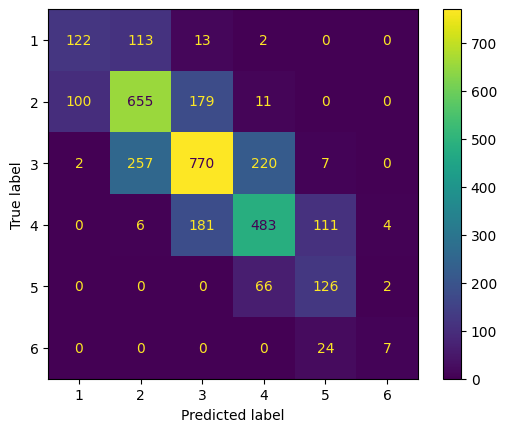

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.200318	valid's QWK: 0.196558
[50]	train's QWK: 0.659189	valid's QWK: 0.65524
[75]	train's QWK: 0.702638	valid's QWK: 0.695795
[100]	train's QWK: 0.730601	valid's QWK: 0.718731
[125]	train's QWK: 0.75259	valid's QWK: 0.748612
[150]	train's QWK: 0.765587	valid's QWK: 0.765567
[175]	train's QWK: 0.774932	valid's QWK: 0.772906
[200]	train's QWK: 0.782044	valid's QWK: 0.78413
[225]	train's QWK: 0.790334	valid's QWK: 0.791293
[250]	train's QWK: 0.796471	valid's QWK: 0.793965
[275]	train's QWK: 0.801194	valid's QWK: 0.799154
[300]	train's QWK: 0.803546	valid's QWK: 0.801258
[325]	train's QWK: 0.807094	valid's QWK: 0.801779
[350]	train's QWK: 0.80928	valid's QWK: 0.803467
[375]	train's QWK: 0.811337	valid's QWK: 0.805976
[400]	train's QWK: 0.812229	valid's QWK: 0.808532
[425]	train's QWK: 0.813792	valid's QWK: 0.809328
[450]	train's QWK: 0.815276	valid's QWK:

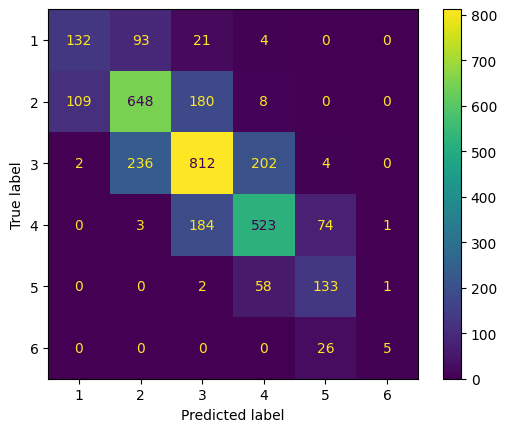

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.202642	valid's QWK: 0.195905
[50]	train's QWK: 0.647815	valid's QWK: 0.639094
[75]	train's QWK: 0.699738	valid's QWK: 0.698117
[100]	train's QWK: 0.732107	valid's QWK: 0.728532
[125]	train's QWK: 0.752748	valid's QWK: 0.749465
[150]	train's QWK: 0.768261	valid's QWK: 0.759428
[175]	train's QWK: 0.777458	valid's QWK: 0.768178
[200]	train's QWK: 0.784434	valid's QWK: 0.775321
[225]	train's QWK: 0.792544	valid's QWK: 0.782235
[250]	train's QWK: 0.797198	valid's QWK: 0.787659
[275]	train's QWK: 0.801245	valid's QWK: 0.791381
[300]	train's QWK: 0.804866	valid's QWK: 0.791705
[325]	train's QWK: 0.806851	valid's QWK: 0.794901
[350]	train's QWK: 0.809299	valid's QWK: 0.797733
[375]	train's QWK: 0.811915	valid's QWK: 0.799121
[400]	train's QWK: 0.813708	valid's QWK: 0.799339
[425]	train's QWK: 0.815165	valid's QWK: 0.799
[450]	train's QWK: 0.816475	valid's QWK

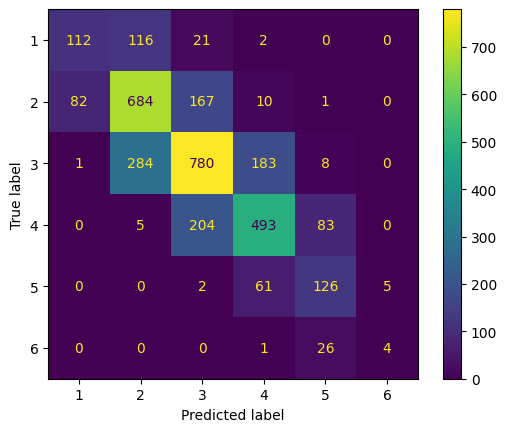

In [23]:
for idx, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    predictor = train_loop(X_train, y_train, X_valid, y_valid)

    with open(f"output/LGBM/{idx}.pkl", "wb") as file:
        pkl.dump(predictor, file)